In [1]:
import torch
import torch.nn as nn
from transformers import CLIPVisionModelWithProjection, ViTForImageClassification, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer, LlamaForCausalLM

import sys, os, json, math
from tqdm import tqdm
import numpy as np

from scipy.stats import pearsonr, spearmanr

import re
import matplotlib.pyplot as plt
std = 0.012528747320175171

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
lyr_list = ['q', 'k', 'v', 'o', 'up', 'gate', 'down']
keys = ['proxy_err', 'bpp_loss', 'err', 'mse', 'tr(WHW.T)']
path = [
    '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/ql/lmbda300_result.json',
    '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/ql_lnorm/lmbda300_result.json',
    '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/ql_cnorm/lmbda300_result.json',
    '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/ql_rnorm/lmbda300_result.json',
    # '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/ql_pe/lmbda50_result.json',
]
# path = [
#     # '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/ql/lmbda100_result.json',
#     # '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/ql_lnorm/lmbda100_result.json',
#     # '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/ql_cnorm/lmbda100_result.json',
#     # '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/ql_rnorm/lmbda100_result.json',
#     # # '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/ql_lnorm_trained/lmbda1000_result.json',
#     # '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/ql_rnorm_trained/lmbda100_result.json'
# ]
label = [
    'ql',
    'ql_lnorm',
    'ql_cnorm',
    'ql_rnrom',
    # 'ql_rnrom_train',
    # 'ql_pe'
]

# path = [
#     '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Llama-2-7b-hf/ql_lnorm/lmbda100_result.json',
#     # '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Llama-2-7b-hf/ql_qs_optim100_lnorm/lmbda50_result.json',
#     # '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Llama-2-7b-hf/ql_8b/lmbda100_result.json',
#     # '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Llama-2-7b-hf/ql_qs_optim100/lmbda100_result.json',
#     '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Llama-2-7b-hf/ql_qs_optim100_lnorm/lmbda100_result.json',
# ]
# label = [
#     'ql_lnrom',
#     # 'ql_lnorm_optim',
#     # 'ql',
#     'ql_qs_optim_lnrom',
#     # 'ql_lnrom'
# ]

path = [
    '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/ql/lmbda100_result.json',
    '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/ql_pe/lmbda100_result.json',
]
label = [
    'ql',
    'ql_pe',
]

path = [
    '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/ql_lnorm/lmbda100_result.json',
    '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/scaleH/size128_encdim1024_M128_ql1/100_result.json',
    '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/scaleH2/size128_encdim1024_M256_ql1/100_result.json',
    '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Meta-Llama-3-8B/scaleH_pe/size128_encdim1024_M256_ql1/lmbda100_result.json',
]
label = [
    'ql_lnorm',
    'scaleh',
    'scaleh2',
    'scaleh2_pe',
]
# path = [
#     # '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Llama-2-7b-hf/ql_qmap_5_10000/qmap_optim_result.json',
#     # '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Llama-2-7b-hf/ql_qmap_5_10000/qmap_uniform0.5_result.json',
#     # '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Llama-2-7b-hf/ql_qmap_5_10000/qmap_hesssian_alpha1_result.json',
#     '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Llama-2-7b-hf/ql_8b/lmbda100_result.json',
#     '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Llama-2-7b-hf/ql_8b/lmbda50_result.json',
#     # '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Llama-2-7b-hf/ql_qmap2/lmbda50_hessian_ql_result.json',
#     # '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Llama-2-7b-hf/ql_qmap2_optim/lmbda50_result.json',
#     '/workspace/Weight_compression/hf_model_comp_results/meta-llama--Llama-2-7b-hf/ql_qmap2/lmbda50_hessian_ql_result.json'
# ]
# label = [
#     # 'qmap_optim_result',
#     # 'qmap_uniform0.5_result',
#     # 'qmap_hesssian_alpha1_result',
#     'ql_100',
#     'ql_50',
#     # 'qmap2_lmbda50_hessian_ql',
#     # 'qmap2_optim_50',
#     'qmap2_ql_50'
# ]

data = {}

for l, p in zip(label, path):
    with open(p) as f:
        result = json.load(f)
    data[l] = {}
    for k in keys:
        data[l][k] = {}
        for i in range(32):
            for lyr in lyr_list:
                data[l][k][f'{i}_{lyr}.pt'] = result[f'{i}_{lyr}.pt'][k]

# # qtip
# data['qtip'] = {}
# label.append('qtip')
# for k in keys:
#     data['qtip'][k] = {}
# for i in range(32):
#     for lyr in lyr_list:
#         path = f'/workspace/Weight_compression/hf_model_comp/qtip/ckpt/3_8b_ft1/3_8b_4bit/{i}_{lyr}.pt'
#         l = torch.load(path)
#         for k in keys:
#             try:
#                 data['qtip'][k][f'{i}_{lyr}.pt'] = l[k]
#                 data['qtip']['bpp_loss'][f'{i}_{lyr}.pt'] = 4
#             except Exception as e:
#                 # print(e)
#                 pass

In [3]:
def get_blocks(model):
    if model.__class__.__name__ in ("LlamaForCausalLM", "Qwen2ForCausalLM"):
        layers = model.model.layers
    elif model.__class__.__name__ == "LlavaLlamaForCausalLM":
        layers = model.model.layers
    return layers

def get_named_linears(module):
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_model_weight_stats(model, data):
    weights = []
    layers = get_blocks(model)
    
    lyr_list = ['q', 'k', 'v', 'o', 'up', 'gate', 'down']
    keys = ['proxy_err', 'bpp_loss', 'err', 'mse', 'tr(WHW.T)']
    layer_name_map = {
        'self_attn.q_proj': 'q',
        'self_attn.k_proj': 'k',
        'self_attn.v_proj': 'v',
        'self_attn.o_proj': 'o',
        'mlp.up_proj': 'up',
        'mlp.gate_proj': 'gate',
        'mlp.down_proj': 'down',
    }
    data['stats'] = {}
    data['stats']['std'] = {}    
    
    for i in tqdm(range(len(layers)), desc="calculating model weight mean & std"):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            w = m.weight.data.detach()
            w = w.reshape(-1, 1024)
            weights.append(w)
            l = layer_name_map[n]
            data['stats']['std'][f'{i}_{l}.pt'] = w.std()
    
    weights = torch.cat(weights, dim = 0)
    
    # mean = weights.mean(0)
    # std = weights.std(0)
    mean = weights.mean()
    std = weights.std()
            
    return mean, std

# model_path = "/workspace/Weight_compression/Wparam_dataset/hf_model/meta-llama--Meta-Llama-3-8B"
# model = AutoModelForCausalLM.from_pretrained(model_path,
#                                                 torch_dtype='auto',
#                                                 low_cpu_mem_usage=True,
#                                                 local_files_only=True,)
# mean, std = get_model_weight_stats(model, data)

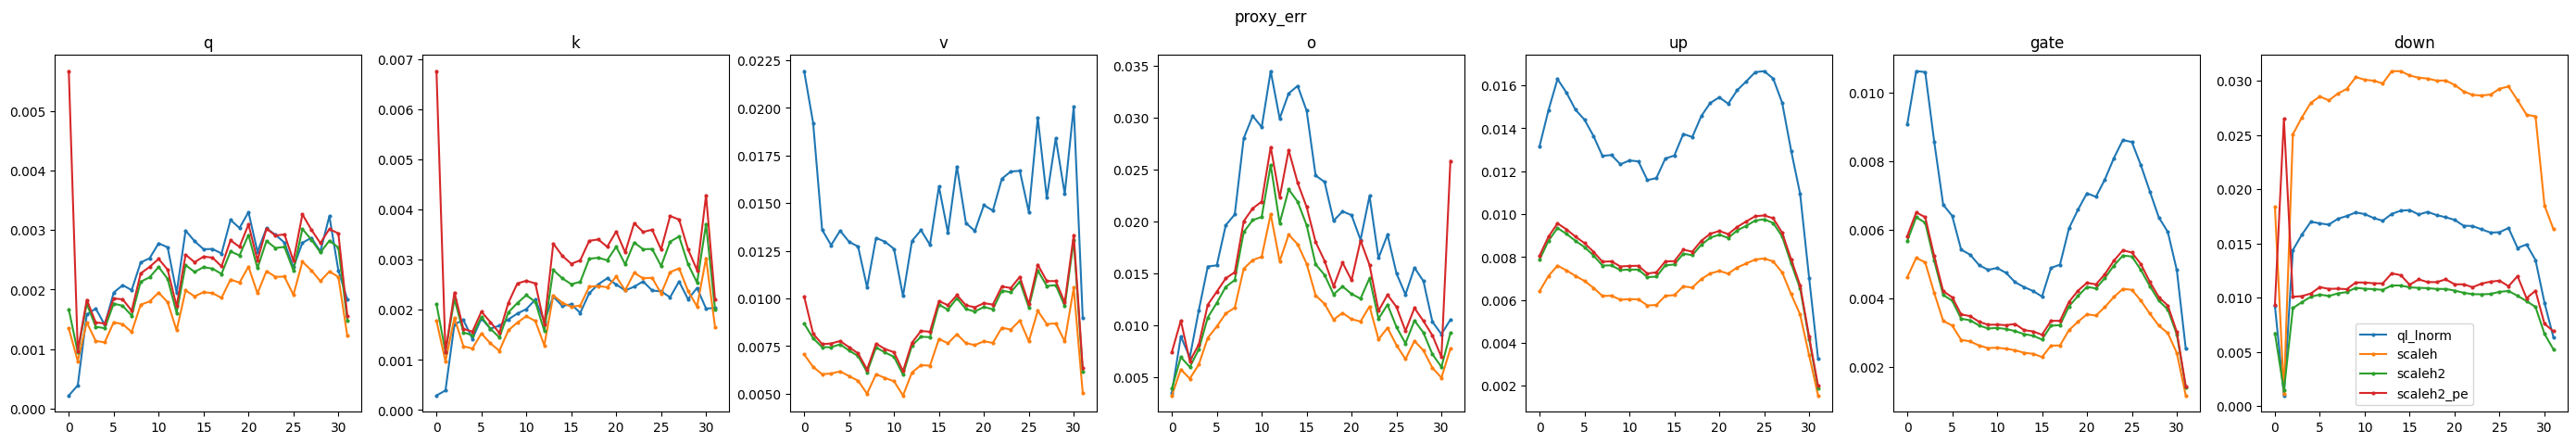

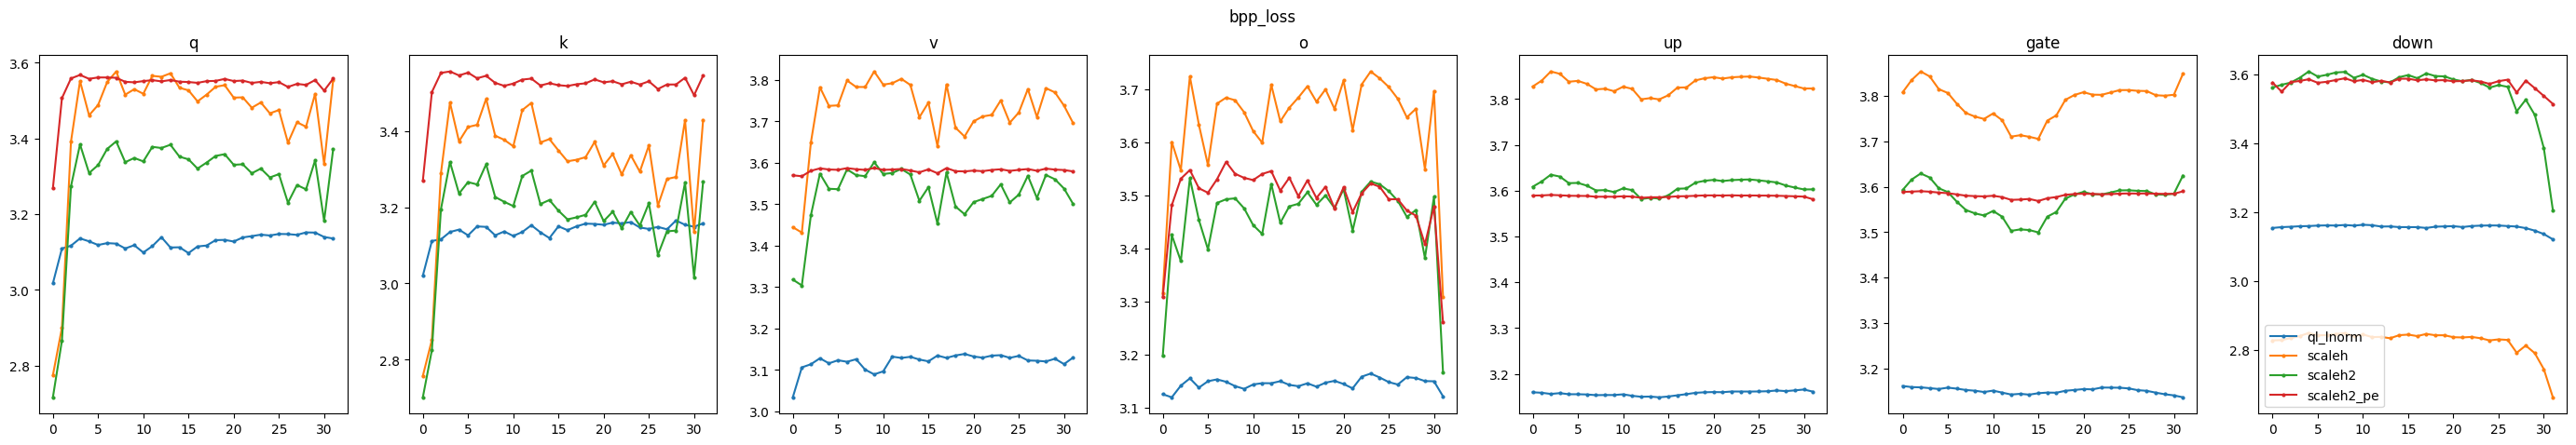

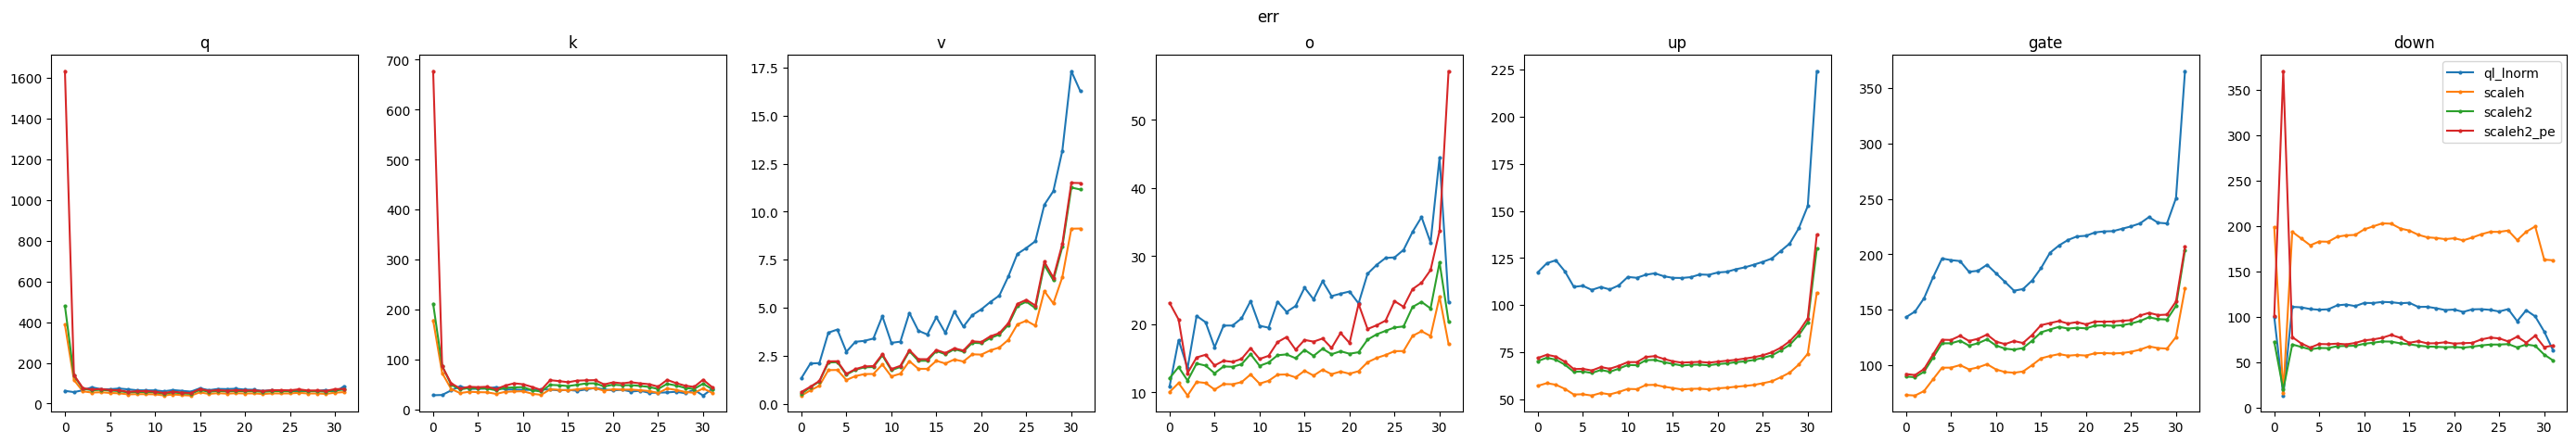

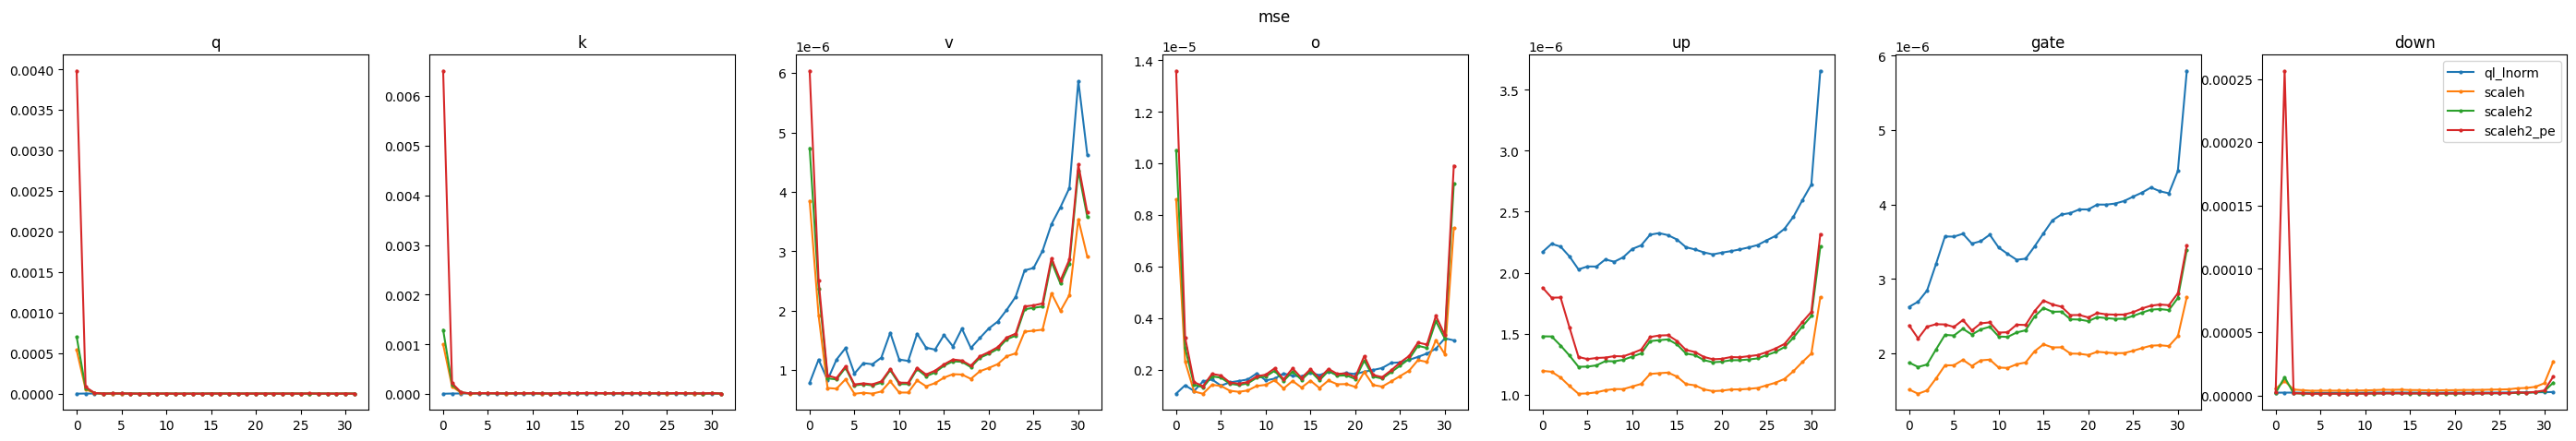

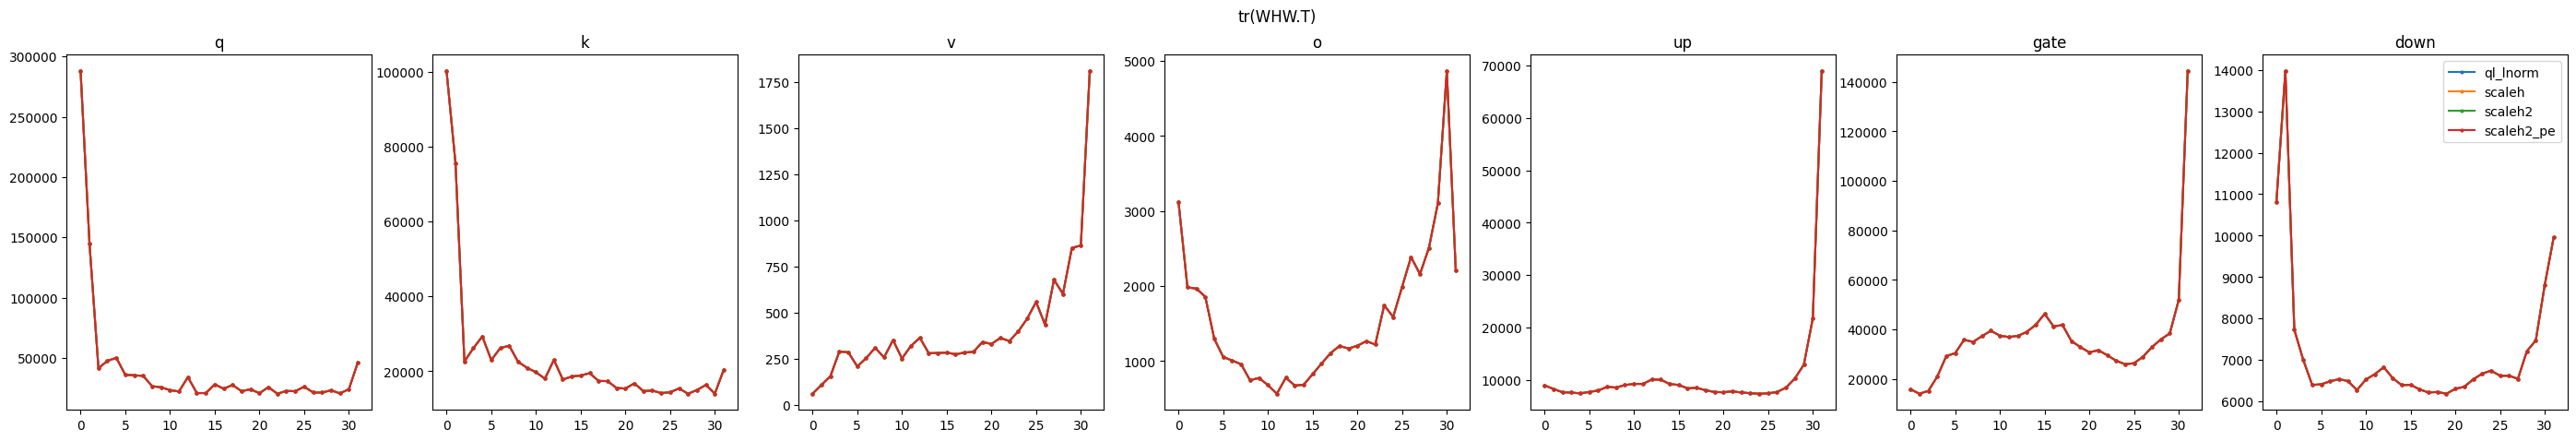

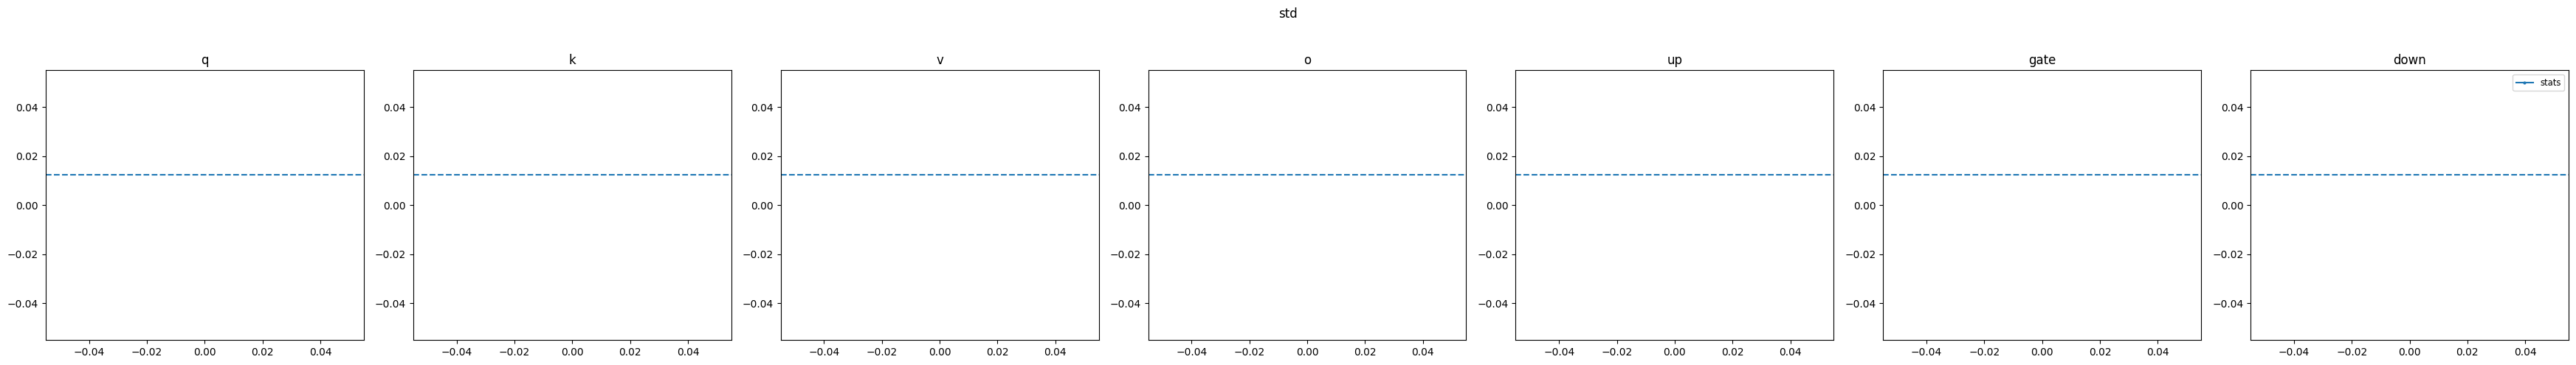

In [4]:
for k in keys:
    fig, axes = plt.subplots(1, 7, figsize=(5*len(lyr_list), 5))
    for i,lyr in enumerate(lyr_list):
        for l in label:
            list = []
            for idx in range(32):
                try:
                    list.append(data[l][k][f'{idx}_{lyr}.pt'])
                except Exception as e:
                    # print(e)
                    pass
            axes[i].plot(list, marker='o', ms='2', label=l)
            axes[i].set_title(lyr)
    plt.suptitle(f'{k}')
    plt.legend()
    plt.show()

fig, axes = plt.subplots(1, 7, figsize=(5*len(lyr_list), 5))
for i,lyr in enumerate(lyr_list):
    l = 'stats'
    k = 'std'
    list = []
    for idx in range(32):
        try:
            list.append(data[l][k][f'{idx}_{lyr}.pt'])
        except Exception as e:
            # print(e)
            pass
    axes[i].plot(list, marker='o', ms='2', label=l)
    axes[i].set_title(lyr)
    axes[i].axhline(y=std, linestyle='--')

plt.suptitle(f'{k}')
plt.legend(fontsize='small')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


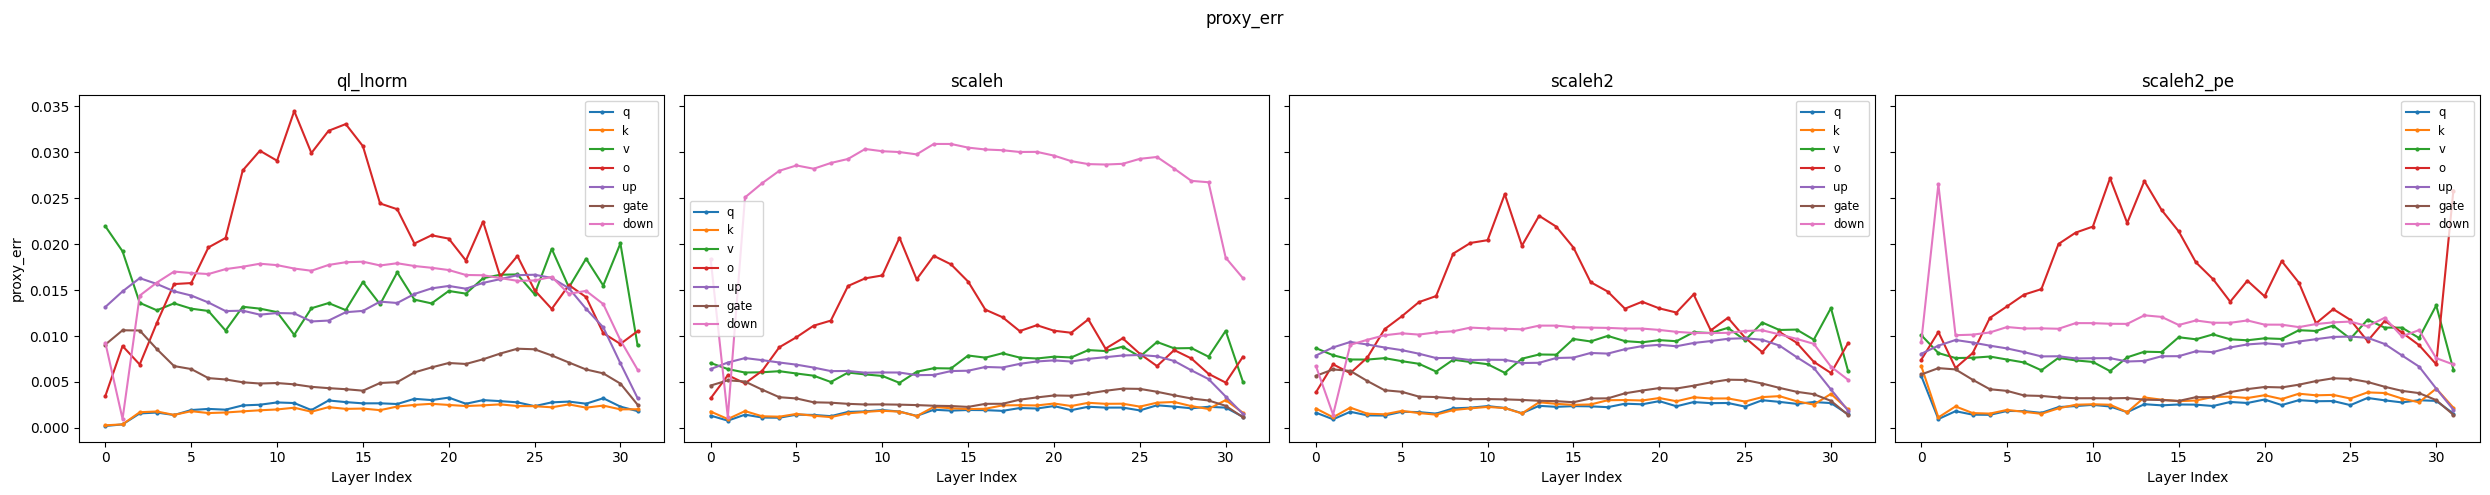

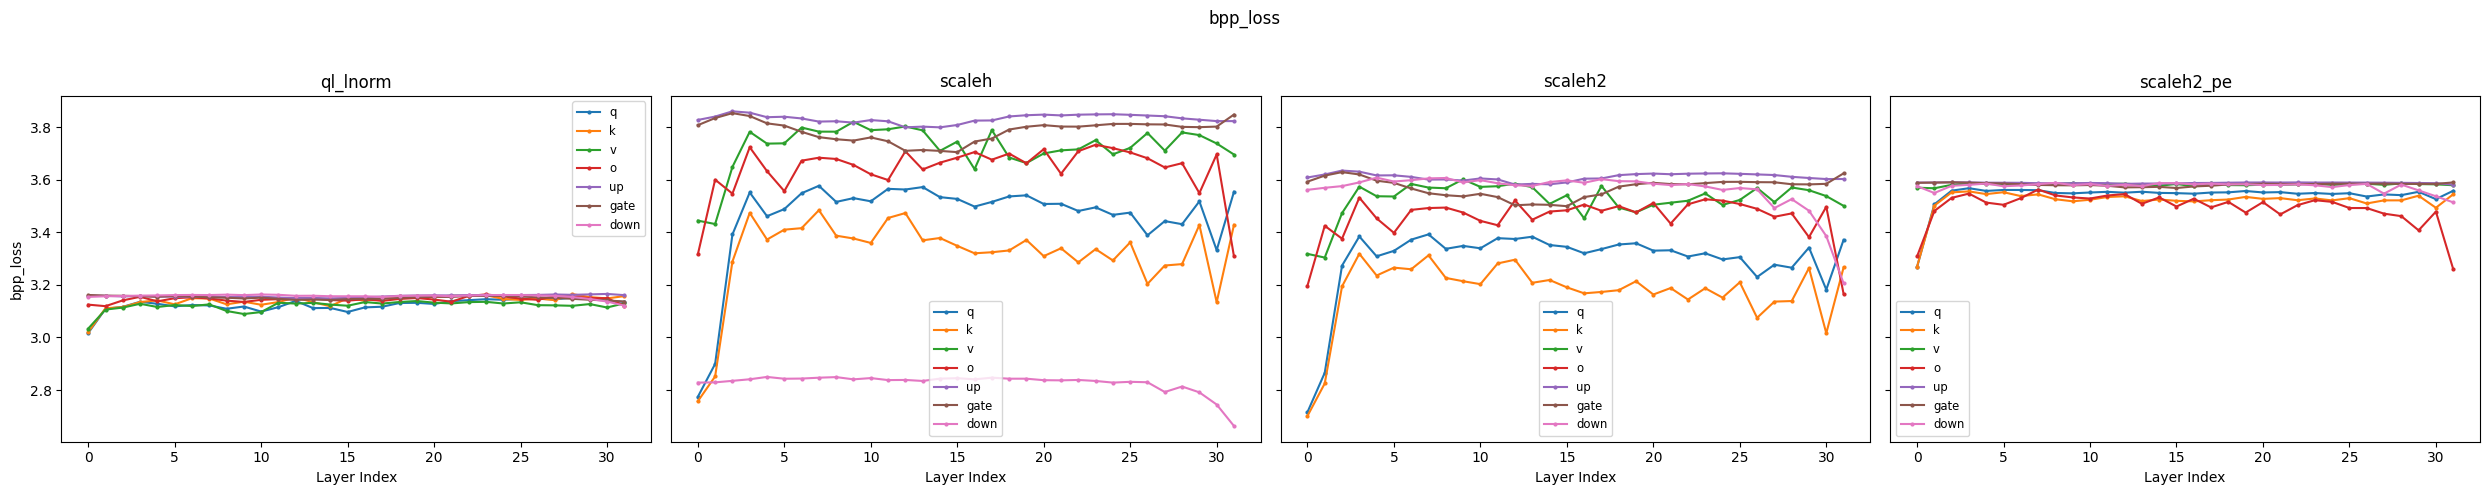

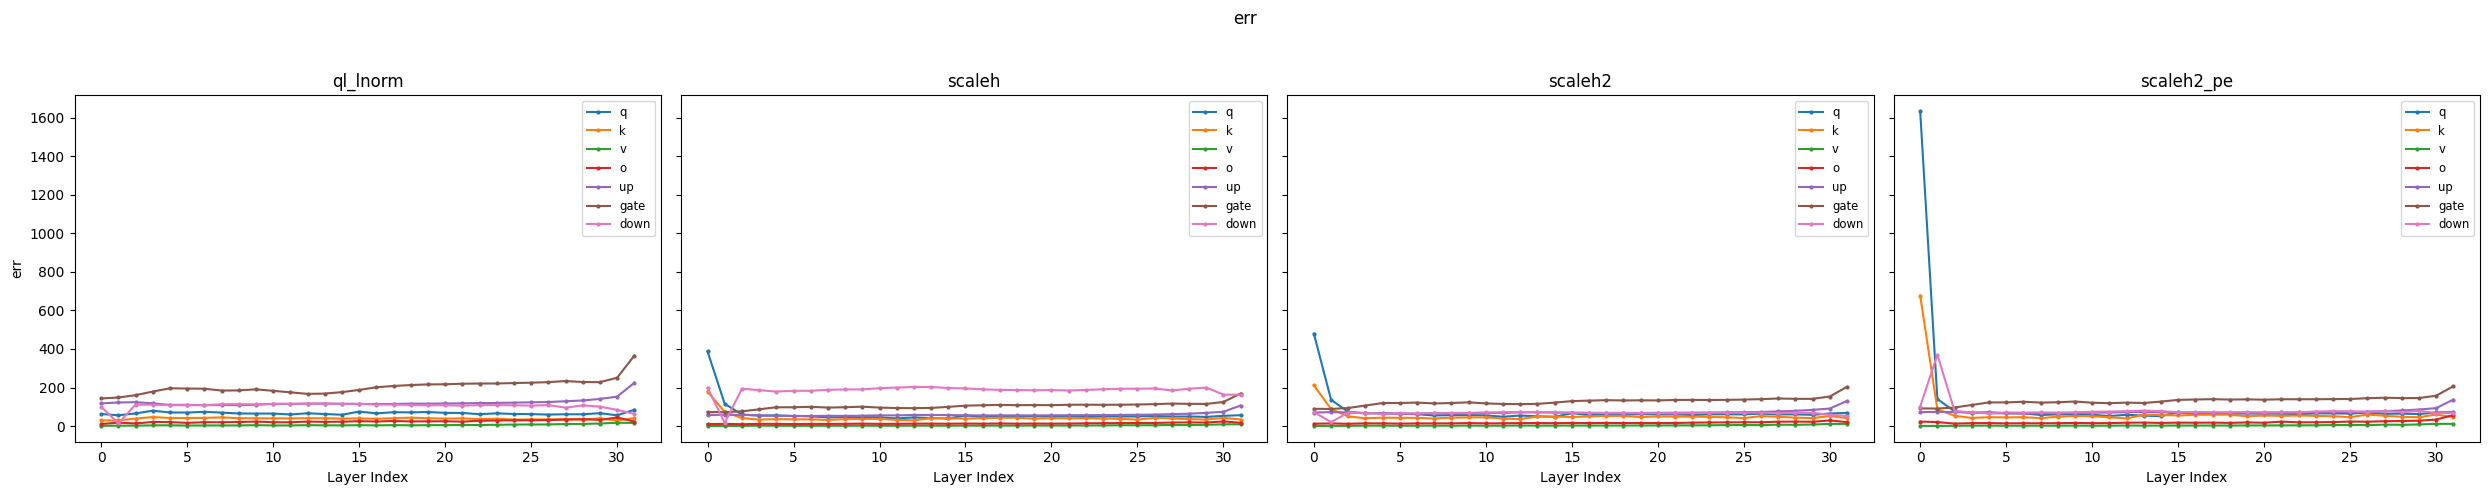

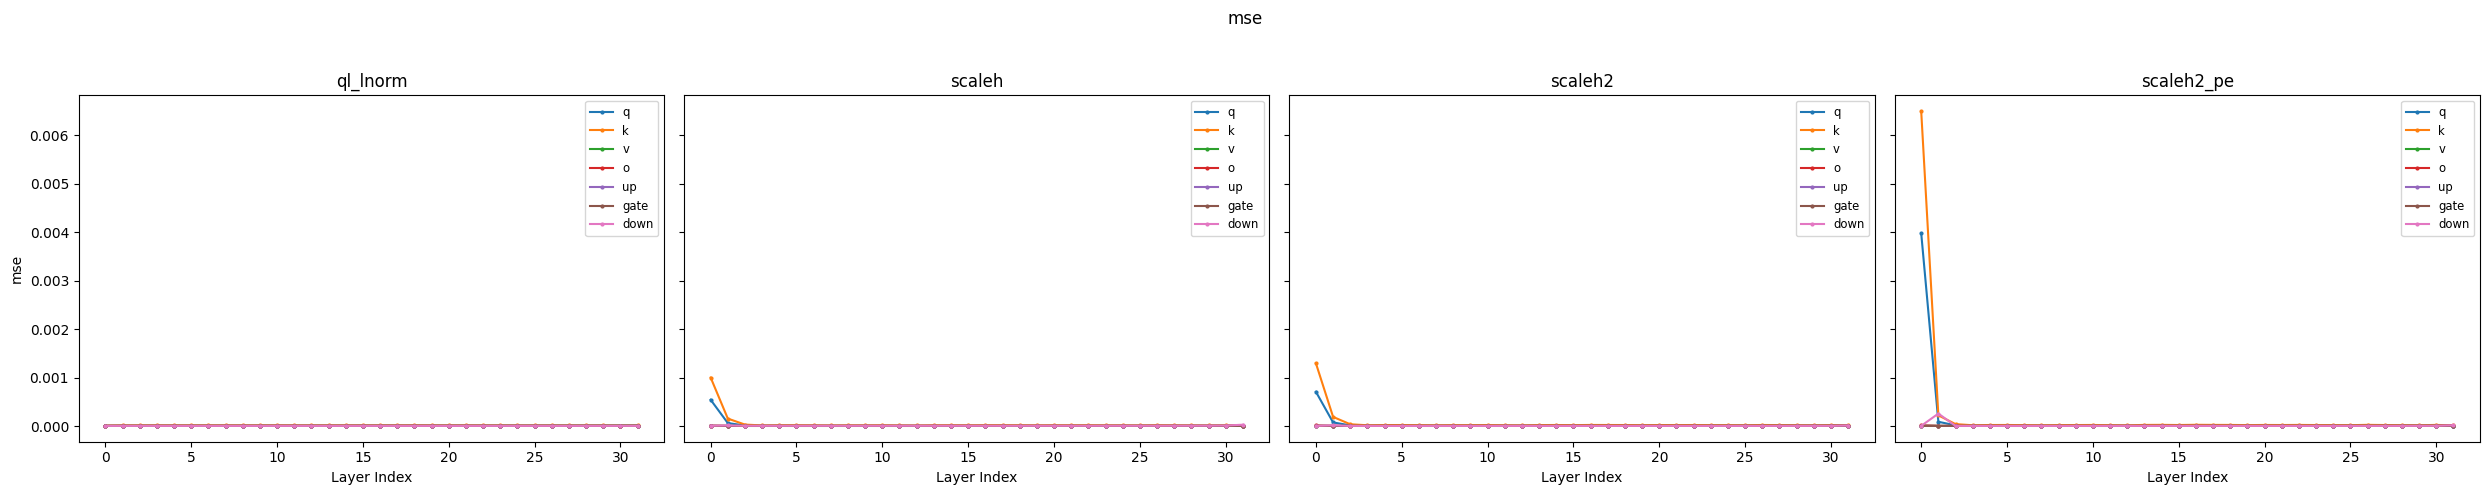

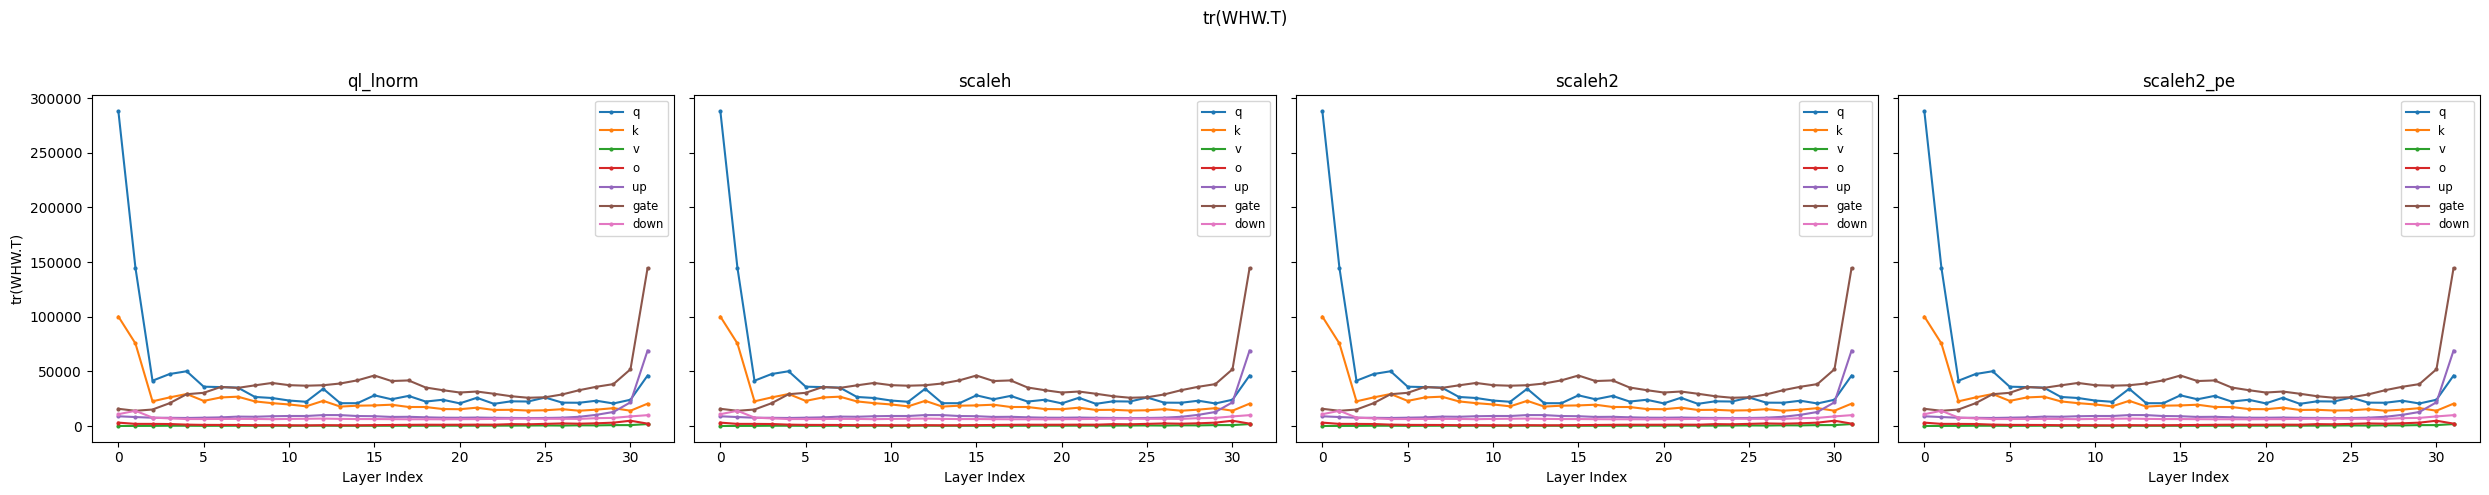

KeyError: 'stats'

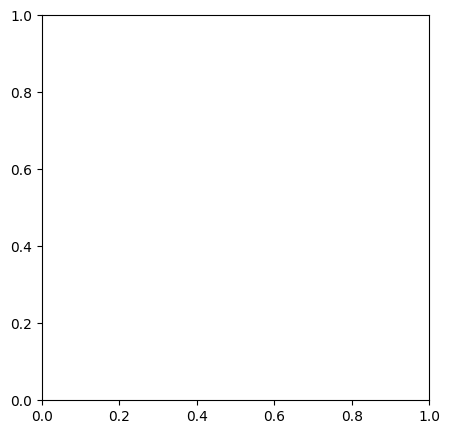

In [5]:
for k in keys:
    fig, axes = plt.subplots(1, len(label), figsize=(5 * len(keys), 5), sharey=True)
    
    for i, l in enumerate(label):
        ax = axes[i] if len(keys) > 1 else axes
        for lyr in lyr_list:
            values = []
            for idx in range(32):
                try:
                    values.append(data[l][k][f'{idx}_{lyr}.pt'])
                except Exception:
                    pass
            ax.plot(values, marker='o', ms=2, label=lyr)
        
        ax.set_title(f'{l}')
        ax.set_xlabel("Layer Index")
        if i == 0:
            ax.set_ylabel(k)
        ax.legend(fontsize='small')

    plt.suptitle(f"{k}")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

l = 'stats'
k = 'std'
fig, axes = plt.subplots(figsize=(5, 5))
for i,lyr in enumerate(lyr_list):
    list = []
    for idx in range(32):
        list.append(data[l][k][f'{idx}_{lyr}.pt'])
    axes.plot(list, marker='o', ms='2', label=lyr)
axes.axhline(y=std, linestyle='--')

plt.suptitle(f'{k}')
plt.legend(fontsize='small')
plt.show()